# Credable Futures Hackathon Project:Revenue Maximization Excercize.

## Introduction.
Businesses have a challenge of trying to maximize profits based on the factors surrounding the business. The other challenge they face is they also need to predict future sales of their products to determine how they can be able to prepare adequately and increase their revenue. The aim of this project is to be able to solve the two issues.

In [72]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

## Data Understanding.

The data is obtained from the Credable futures hackathon which was cleaned first via google sheets. Below is the view of the data.

In [73]:
# Having a look at the data.
data = pd.read_csv("Futures Credable Hackathon Dataset - Sheet1.csv")
data

,Month,1/31/19,2/28/19,3/31/19,4/30/19,5/31/19,6/30/19,7/31/19,8/31/19,9/30/19,...,3/31/23,4/30/23,5/31/23,6/30/23,7/31/23,8/31/23,9/30/23,10/31/23,11/30/23,12/31/23
0,Volume (units),"10,000","10,200","10,404","10,612","10,824","11,041","11,262","11,487","11,717",...,"26,916","27,454","28,003","28,563","29,135","29,717","30,312","30,918","31,536","32,167"


It can be noted that the data needs to be changed from the wide format to the long format for it to be more understable.

In [74]:
# Changing the data to the long format
data = pd.melt(data)
data

,variable,value
0,Month,Volume (units)
1,1/31/19,"10,000"
2,2/28/19,"10,200"
3,3/31/19,"10,404"
4,4/30/19,"10,612"
...,...,...
56,8/31/23,"29,717"
57,9/30/23,"30,312"
58,10/31/23,"30,918"
59,11/30/23,"31,536"


We also need to change the first index into column names.

In [75]:
# Changing the first index into columns.
data.columns = data.iloc[0]
data = data[1:]
data = data.reset_index(drop=True)
data

,Month,Volume (units)
0,1/31/19,"10,000"
1,2/28/19,"10,200"
2,3/31/19,"10,404"
3,4/30/19,"10,612"
4,5/31/19,"10,824"
5,6/30/19,"11,041"
6,7/31/19,"11,262"
7,8/31/19,"11,487"
8,9/30/19,"11,717"
9,10/31/19,"11,951"


We can now have a look at our data characteristics.

In [76]:
print(data.shape)
print(data.info())
data.describe()

(60, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Month           60 non-null     object
 1   Volume (units)  60 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB
None


,Month,Volume (units)
count,60,60
unique,60,60
top,1/31/19,"10,000"
freq,1,1


We can see that our data has 60 rows and two columns. Both columns are of the object datatype. The `month` column shows the month of the sales volume whereas the volume in units shows the total sales volumes per day for the time period.

We can now head to data cleaning.

## Data cleaning.

For this stage, we need to look for missing, duplicate and placeholder values, outliers and to change the datatypes. We will begin by creating a function that checks for the missing, duplicate and placeholder values.

In [77]:
# Creating the function that checks for missing, duplicate and placeholder values.
def checking_values(df):
  # Missing values
  print(f'Number of missing values in each column:\n{df.isnull().sum()}\n')
  # Duplicate values
  print(f'Number of duplicate values in the dataset: {df.duplicated().sum()}\n')
  #Placeholder values
  for column in df.columns:
        unique_values = df[column].unique()
        placeholders = [value for value in unique_values if str(value).strip().lower() in ['placeholder', 'na', 'n/a', '?']]
        placeholder_count = len(placeholders)

        print(f"Column: '{column}'")
        print(f"Placeholders found: {placeholders}")
        print(f"Count of placeholders: {placeholder_count}\n")

# Checking our dataset
checking_values(data)


Number of missing values in each column:
0
Month             0
Volume (units)    0
dtype: int64

Number of duplicate values in the dataset: 0

Column: 'Month'
Placeholders found: []
Count of placeholders: 0

Column: 'Volume (units)'
Placeholders found: []
Count of placeholders: 0



We can see that the dataset has none of the above mentioned values in the dataset. We will now change the `Volume` column from an object datatype to an integer datatype and check for the outliers in the column.

In [78]:
# Removing the commas from the values
data["Volume (units)"] = data["Volume (units)"].str.replace(",", "")
# Changing the values into integers
data["Volume (units)"] = data["Volume (units)"].astype("int")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Month           60 non-null     object
 1   Volume (units)  60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


We can go ahead and check for the outliers

In [79]:
#Checking for outliers
def check_outliers(df, columns):
    for column in columns:
        # Calculate IQR (Interquartile Range)
        iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

        # Define lower and upper thresholds
        lower_threshold = df[column].quantile(0.25) - 1.5 * iqr
        upper_threshold = df[column].quantile(0.75) + 1.5 * iqr

# Find outliers
        outliers = df[(df[column] < lower_threshold) | (df[column] > upper_threshold)]

        # Print the count of outliers
        print(f"{column}\nNumber of outliers: {len(outliers)}\n")

# Calling the function
columns_to_check = data.select_dtypes(include = ['number'])
check_outliers(data, columns_to_check)

Volume (units)
Number of outliers: 0



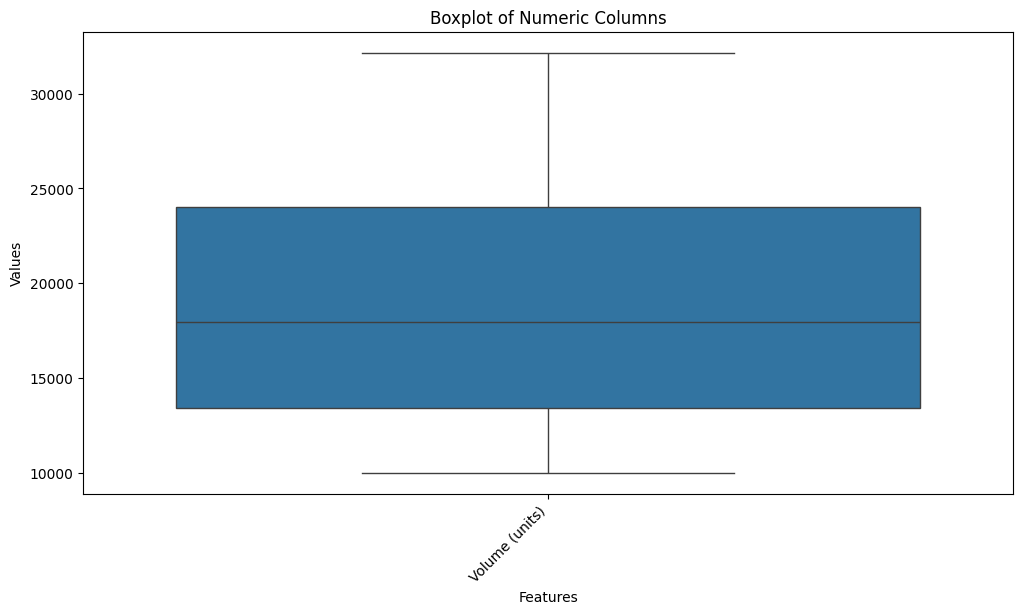

In [80]:
# Plotting a boxplot to check for outliers
features_to_plot = data.select_dtypes(include = ['number'])
plt.figure(figsize=(12,6))
sns.boxplot(data=features_to_plot, ax=plt.gca())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Numeric Columns')
plt.show()

We can see that our data has no outliers. Since this is a time series project, we will change the date column to datetime.

In [82]:

data["Month"] = pd.to_datetime(data["Month"], format='mixed')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month           60 non-null     datetime64[ns]
 1   Volume (units)  60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


We can now head over and conduct Exploratory Data Analysis.

## Exploratory Data Analysis.

We will begin by looking at the distribution of the `Volumes` column.

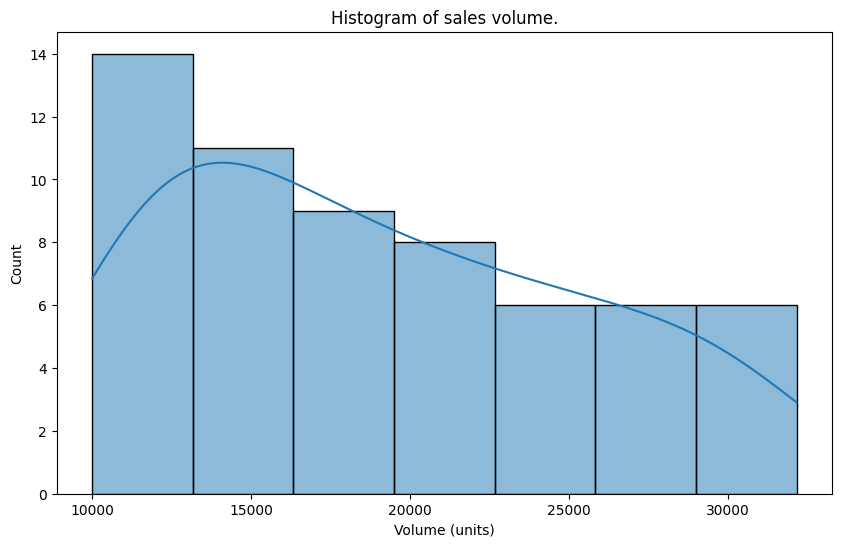

In [83]:
# Creating histograms for selected columns
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Volume (units)', bins = 'auto', common_norm = False, kde = True)
plt.title('Histogram of sales volume.')
plt.show()

From the histogram and the accompanying KDE plot, we can see that our data isn't normally distributed but has a positive skew. We can also have a look at the trend of our data by plotting a line plot. That means we have to set the `Month` column as the index.

<Axes: xlabel='Month'>

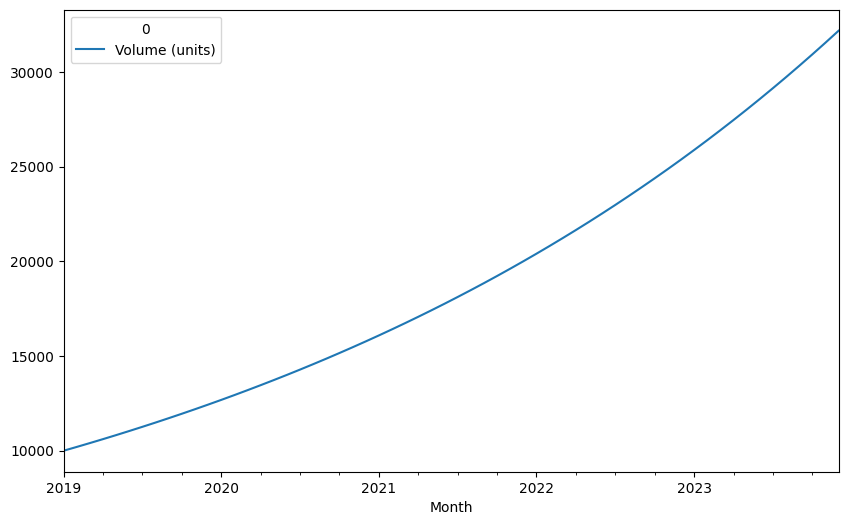

In [84]:
# Setting Month as index
data_ts = data.set_index("Month")
# Line plot of the time series data.
data_ts.plot(figsize=(10,6))

From the line plot we can see that the data has an upward trend. We can also check for seasonality in the data.

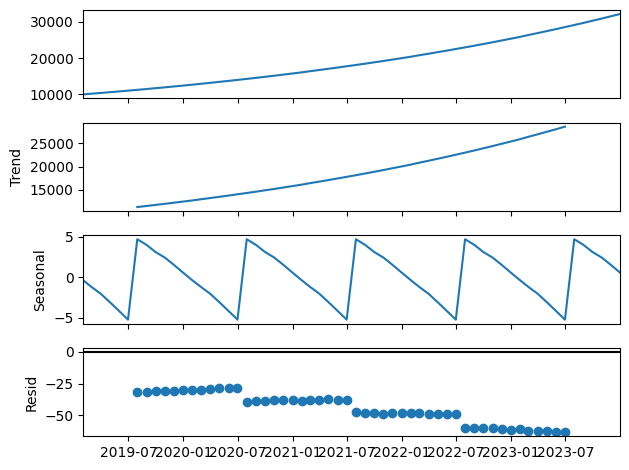

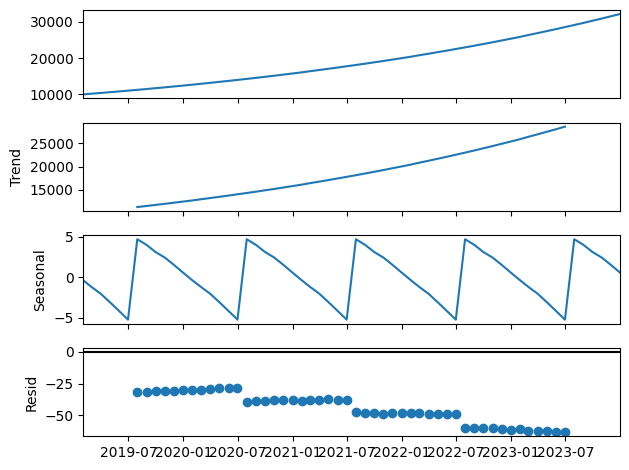

In [85]:
# Checking for seasonality and trend
decomposition = seasonal_decompose(data_ts)
decomposition.plot()

From the plot above we can see that there is also seasonality in the data. We can also check for the rolling statistics.

In [86]:
# Rolling mean
roll_mean = data_ts.rolling(window=12, center=False).mean()
roll_std = data_ts.rolling(window=12, center=False).std()

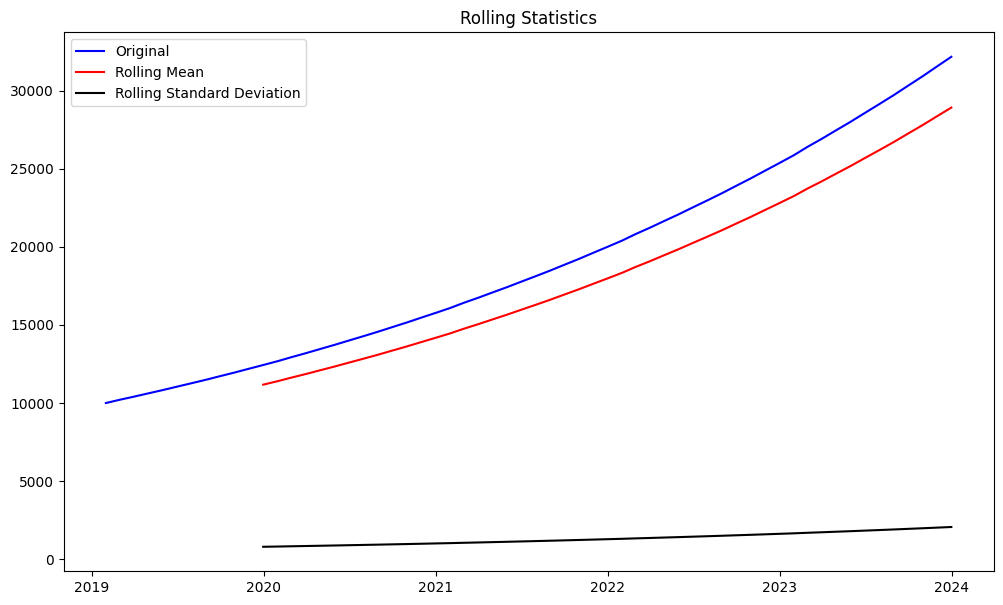

In [87]:
# Plotting the rolling statistics
fig = plt.figure(figsize=(12,7))
plt.plot(data_ts, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label='Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show(block=False);

From the plot it can be seen that the rolling mean follows the same trend as the data. We can also test for stationarity using the Augmented Dickey-Fuller test. We will set our alpha as 0.05

In [88]:
# Dickey-Fuller Test
dftest = adfuller(data_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Values (%s)'%key] = value

print('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  5.461450
p-value                         1.000000
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Values (1%)           -3.562879
Critical Values (5%)           -2.918973
Critical Values (10%)          -2.597393
dtype: float64


Since the p-value is greater than the set alpha, we can see that the data is not stationary. This has also been proven by the rolling statistics.

## Revenue maximization.

We will try to find the profit to be made with the assumptions given for the challenge. We will first try to find the number

In [132]:
total = data["Volume (units)"].sum()
total

1140514

In [135]:
total_tv = 993,710
minu = 1140514 - 993710
minu

146804

## Time Series Modeling

In [91]:
# Resampling the data to daily
data_ts2 = data_ts.copy()
data_ts2 = data_ts2.resample('D').asfreq()
# Filling the null values
data_ts2 = data_ts2.interpolate(method='linear', axis=0, limit_direction='forward')
data_ts2.shape

(1796, 1)

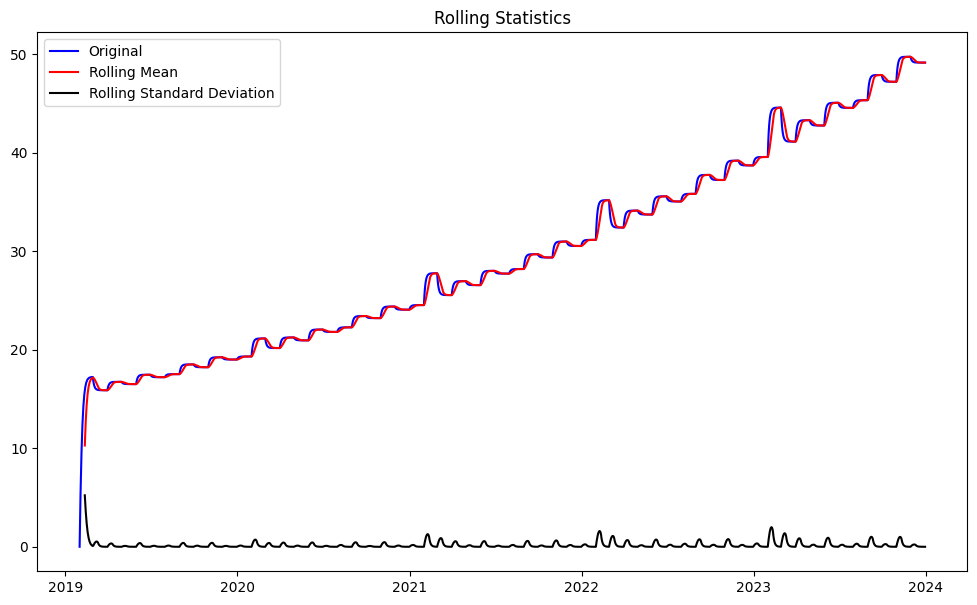

In [93]:

exp_rolling_mean = data_ts2.ewm(halflife=2).mean()
data_ts2_minus_exp_roll_mean = data_ts2 - exp_rolling_mean
roll_mean2 = data_ts2_minus_exp_roll_mean.rolling(window=12, center=False).mean()
roll_std2 = data_ts2_minus_exp_roll_mean.rolling(window=12, center=False).std()

#Plot
fig = plt.figure(figsize=(12,7))
plt.plot(data_ts2_minus_exp_roll_mean, color='blue', label='Original')
plt.plot(roll_mean2, color='red', label='Rolling Mean')
plt.plot(roll_std2, color='black', label='Rolling Standard Deviation')

plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show(block=False);

In [95]:
#Differencing the data again
data_diff = data_ts2_minus_exp_roll_mean.diff(periods=1).dropna()
data_diff.head()

,Volume (units)
Month,
2019-02-01,2.958668
2019-02-02,2.566039
2019-02-03,2.195865
2019-02-04,1.854623
2019-02-05,1.546738


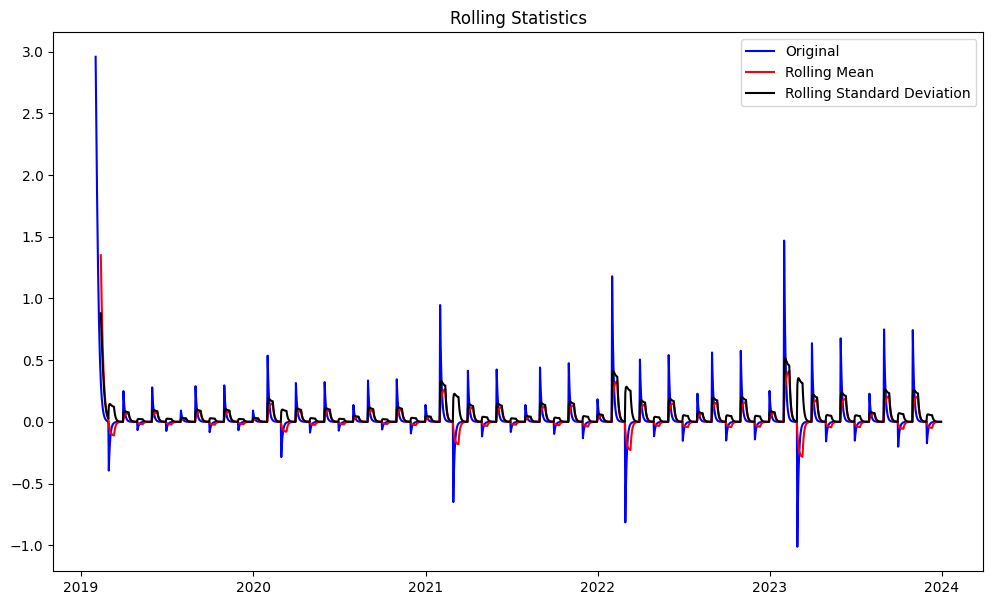

In [96]:
#Plotting to check stationarity

#Calculating rolling mean and rolling standard deviation
roll_mean3 = data_diff.rolling(window=12, center=False).mean()
roll_std3 = data_diff.rolling(window=12, center=False).std()

#Plot
fig = plt.figure(figsize=(12,7))
plt.plot(data_diff, color='blue', label='Original')
plt.plot(roll_mean3, color='red', label='Rolling Mean')
plt.plot(roll_std3, color='black', label='Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show(block=False);

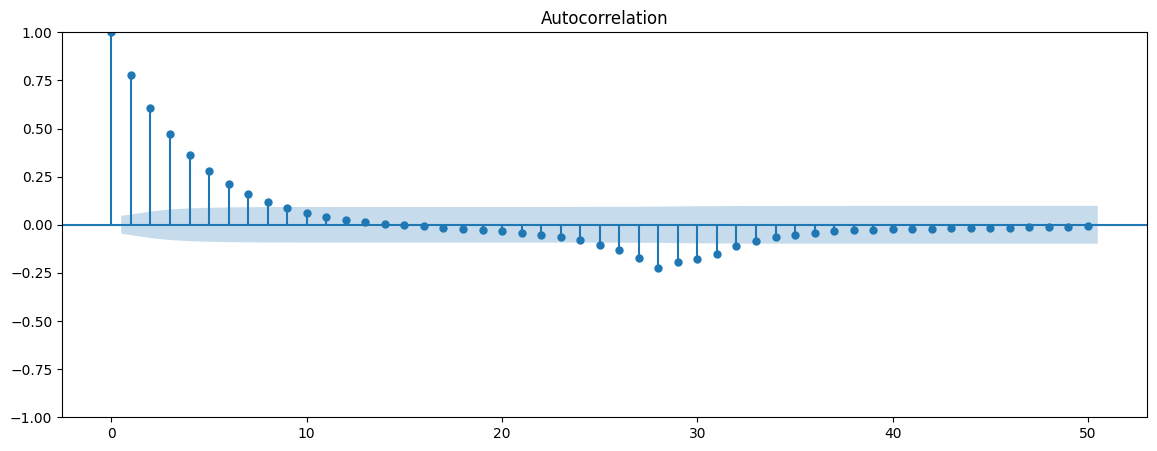

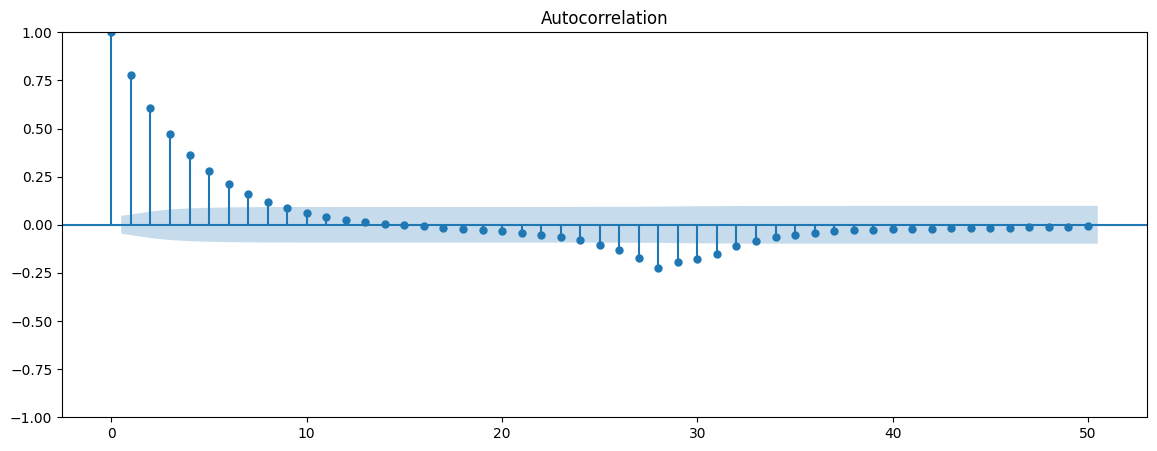

In [98]:
# Plotting ACF
rcParams['figure.figsize'] = 14, 5
plot_acf(data_diff, lags=50)

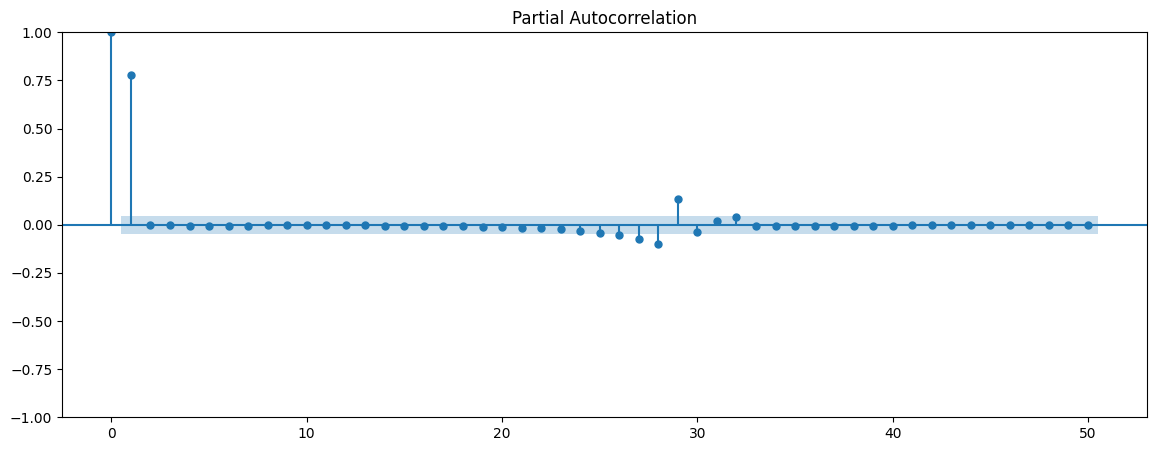

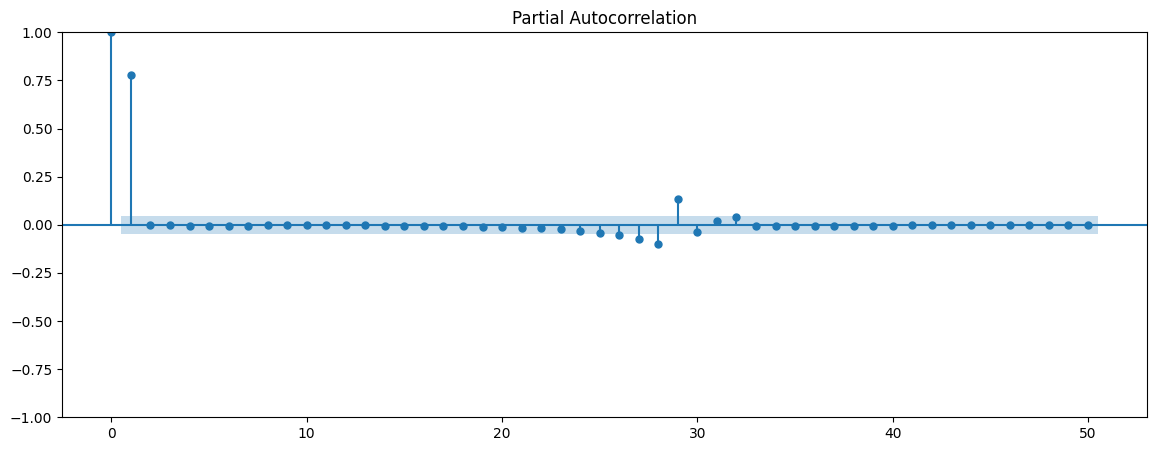

In [99]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(data_diff, lags=50)

In [102]:
#Data splitting at 75% of the data
train_size = int(len(data_diff) * 0.75)
train, test = data_diff.iloc[:train_size], data_diff.iloc[train_size:]
print(train.shape)
print(test.shape)

(1346, 1)
(449, 1)


In [103]:
#Function to calculate rmse and mae
def metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'RMSE: {rmse}\nMAE: {mae}')

In [107]:
#The baseline model
baseline_model = ARIMA(train, order=(1, 0, 1))
res_arima = baseline_model.fit()
y_hat_baseline = res_arima.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Volume (units)   No. Observations:                 1346
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1499.977
Date:                Wed, 01 May 2024   AIC                          -2991.955
Time:                        12:14:40   BIC                          -2971.135
Sample:                    02-01-2019   HQIC                         -2984.157
                         - 10-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3404      0.374      0.910      0.363      -0.393       1.074
ar.L1          0.9947      0.002    570.830      0.000       0.991       0.998
ma.L1         -0.0538      0.011     -4.760      0.000      -0.076      -0.032
sigma2         0.0063    4.6e-05    136.442      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):            311906.53
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             3.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        77.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
metrics(test, y_hat_baseline)

RMSE: 0.25606190137150237
MAE: 0.21722162173655868


In [109]:
# Second ARIMA model
model2 = ARIMA(train, order=(1, 0, 0))
res_arima2 = model2.fit()
y_hat_2 = res_arima2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
res_arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Volume (units)   No. Observations:                 1346
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1498.287
Date:                Wed, 01 May 2024   AIC                          -2990.573
Time:                        12:15:01   BIC                          -2974.959
Sample:                    02-01-2019   HQIC                         -2984.725
                         - 10-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2255      0.246      0.918      0.359      -0.256       0.707
ar.L1          0.9907      0.002    532.198      0.000       0.987       0.994
sigma2         0.0063   4.62e-05    136.228      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   8.24   Jarque-Bera (JB):            308485.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             3.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        76.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
metrics(test, y_hat_2)

RMSE: 0.22215300185158537
MAE: 0.18418116455726521


In [111]:
#Code to iterate through the values of p,d and q modeling each combination
p = range(0, 3)
q = range(0, 3)
d = range(0, 1)

pdq_combinations = list(itertools.product(p, d, q))

rmse = []
order = []

for pdq in pdq_combinations:
    try:
        model = ARIMA(train, order=pdq).fit()
        y_hat = model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        error = np.sqrt(mean_squared_error(test, y_hat))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [112]:
#Results from the code above
results = pd.DataFrame(index=order, data=rmse, columns=['RMSE'])
min_value_order = results.idxmin().values[0]
print(min_value_order)

(0, 0, 0)


In [113]:
# Final ARIMA model
model3 = ARIMA(train, order=(0, 0, 0))
res_arima3 = model2.fit()
y_hat_3 = res_arima2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
res_arima3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Volume (units)   No. Observations:                 1346
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1498.287
Date:                Wed, 01 May 2024   AIC                          -2990.573
Time:                        12:17:47   BIC                          -2974.959
Sample:                    02-01-2019   HQIC                         -2984.725
                         - 10-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2255      0.246      0.918      0.359      -0.256       0.707
ar.L1          0.9907      0.002    532.198      0.000       0.987       0.994
sigma2         0.0063   4.62e-05    136.228      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   8.24   Jarque-Bera (JB):            308485.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             3.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        76.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
metrics(test, y_hat_3)

RMSE: 0.22215300185158537
MAE: 0.18418116455726521


In [122]:
#Resetting the index of the train data
train2 = train.reset_index()
train2 = train2.rename(columns={'Month': 'ds', 'Volume (units)': 'y'})
test2 = test.reset_index()
test2 = test2.rename(columns={'Month': 'ds', 'Volume (units)': 'y'})

In [123]:
#Prophet model with default hyperparameters
prophet_model1 = Prophet()
prophet_model1.fit(train2)
future_dates1 = prophet_model1.make_future_dataframe(periods=len(test2), freq='M')
forecast1 = prophet_model1.predict(future_dates1)
test_predictions1 = forecast1['yhat'][-len(test2):]
metrics(test2['y'], test_predictions1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/vb2vhj61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/wvkiwnmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37584', 'data', 'file=/tmp/tmprxx9gf37/vb2vhj61.json', 'init=/tmp/tmprxx9gf37/wvkiwnmb.json', 'output', 'file=/tmp/tmprxx9gf37/prophet_modelmd0dt55s/prophet_model-20240501122548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.2144633886184439
MAE: 0.15157732379780342


In [124]:
# Manual Hyperparameter tuning for the prophet model
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 1.0],
    "seasonality_mode": ["additive", "multiplicative"],
}

# Perform manual hyperparameter tuning
best_rmse = np.inf
best_params = None

for changepoint_prior_scale in param_grid["changepoint_prior_scale"]:
    for seasonality_mode in param_grid["seasonality_mode"]:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_mode=seasonality_mode,
        )

        # Fit the model on the training data
        model.fit(train2)

        # Make predictions on the validation set
        future = model.make_future_dataframe(periods=len(test2))
        forecast = model.predict(future)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test2["y"], forecast["yhat"][:len(test2)]))

        # Check if the current combination of hyperparameters is the best
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {
                "changepoint_prior_scale": changepoint_prior_scale,
                "seasonality_mode": seasonality_mode,
            }

print("Best Hyperparameters:", best_params)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/4e8bge1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/ku64g0_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39647', 'data', 'file=/tmp/tmprxx9gf37/4e8bge1d.json', 'init=/tmp/tmprxx9gf37/ku64g0_t.json', 'output', 'file=/tmp/tmprxx9gf37/prophet_modelcrsrb_tu/prophet_model-20240501122555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprx

Best Hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [125]:
# Creating a Prophet model using the suggested hyperparameters
param_dict = {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
prophet_model2 = Prophet(**param_dict)
prophet_model2.fit(train2)
future_dates = prophet_model2.make_future_dataframe(periods=len(test2), freq='M')
forecast = prophet_model2.predict(future_dates)
test_predictions2 = forecast['yhat'][-len(test2):]
metrics(test2['y'], test_predictions2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/f6vhunuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/a2vuege5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28173', 'data', 'file=/tmp/tmprxx9gf37/f6vhunuq.json', 'init=/tmp/tmprxx9gf37/a2vuege5.json', 'output', 'file=/tmp/tmprxx9gf37/prophet_modelf5oflahf/prophet_model-20240501122659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.2764877637591551
MAE: 0.21889004498181364


In [126]:
# Define the objective function to optimize
def objective(trial):
    # Create a Prophet model with suggested hyperparameters
    model = Prophet(
        changepoint_prior_scale=trial.suggest_float("changepoint_prior_scale", 0.001, 0.5),
        seasonality_mode=trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
    )
    # Fit the model to the training data
    model.fit(train2)

    # Make predictions on the validation set
    future_dates = model.make_future_dataframe(periods=len(test2), freq='M')
    forecast = model.predict(future_dates)
    test_predictions = forecast['yhat'][-len(test2):]

    # Calculate evaluation metric (e.g., RMSE)
    rmse = np.sqrt(mean_squared_error(test2['y'], test_predictions))

    return rmse  # Minimize RMSE

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Create the best model using the optimal hyperparameters
best_model = Prophet(**best_params)
# Fit the best model to the entire dataset
best_model.fit(train2)

# Predicting the values
future_dates = best_model.make_future_dataframe(periods=len(test2), freq='M')
forecast = best_model.predict(future_dates)
test_predictions3 = forecast['yhat'][-len(test2):]
metrics(test2['y'], test_predictions3)

[I 2024-05-01 12:27:26,136] A new study created in memory with name: no-name-1580ec0b-52a5-4c53-abd2-09c124c01b2e
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/pgkzjcj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx9gf37/w33k3m21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91023', 'data', 'file=/tmp/tmprxx9gf37/pgkzjcj9.json', 'init=/tmp/tmprxx9gf37/w33k3m21.json', 'output', 'file=/tmp/tmprxx9gf37/prophet_modelqp5f4i00/prophet_model-20240501122726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:27:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2024-05-01 12:27:30,524] 

RMSE: 0.20058927080592248
MAE: 0.13891941125852628


From all the models we can see that the Prophet model with the Optuna hyperparameter tuning is the best performing model with an RMSE of about 0.201 and an MAE of about 0.1389.